In [1]:
import pandas as pd
import numpy as np

In [2]:
#sizes = {'real': {'train': 443757, 'val': 214354}, 'abstract': {'train': 60000, 'val': 30000}}

In [3]:
def get_summary(scenario, _set = None, v=''):
    details_train = pd.read_csv('./data/predictions_details_{}_train'.format(scenario), header=None)
    details_train['_set'] = 'train'
    details_val = pd.read_csv('./data/predictions_details_{}_val'.format(scenario), header=None)
    details_val['_set'] = 'val'
    details = pd.concat([details_train, details_val])
    details[2] = details[2].astype(int)
    details.sort_values(by=2, inplace=True)

    prediction = pd.read_csv('./concatenated_data/{}_prediction{}.csv'.format(scenario,v))
    prediction.rename(columns={'2049':'q_type', '2048':'q_id'}, inplace=True)
    
    
    prediction['_set'] = details.set_index(2)[['_set']].loc[prediction['q_id'].astype(int)].values

    #prediction['my_acc'] = (prediction.my_predicted == prediction.my_target).astype(int)
    #prediction['base_acc'] = (prediction.base_predicted == prediction.base_target).astype(int)
    prediction['my_score'] = prediction.score
    prediction['base_score'] = prediction.base_score

    if _set is None:
        sset_prediction = prediction
    else:
        sset_prediction = prediction[prediction._set == _set]
    
    #accs = (sset_prediction[['my_acc','base_acc']].sum()/sset_prediction.shape[0]).values
    scores = (sset_prediction[['my_score','base_score']].sum()/sset_prediction.shape[0]).values


    #print('acc', accs, accs[0] > accs[1])
    print('scores', scores, scores[0] > scores[1])


    accurracies = sset_prediction[['q_type', 'my_score','base_score',
                              'sum_top_down', 'sum_bottom_up']].groupby(['q_type']).sum().reset_index()
                                # 'my_acc','base_acc', 
    accurracies = accurracies.set_index('q_type')
    
    
    new_summary = pd.read_csv('./concatenated_data/queries_summary_{}{}.csv'.format(scenario,v))
    del new_summary['count_top_down']
    new_summary.rename(columns={'2049':'_q_type'}, inplace=True)
    
    
    new_summary = new_summary[new_summary._q_type.isin(accurracies.index.values)]
    new_summary['q_type'] = accurracies.loc[new_summary._q_type.values].index.values
    #new_summary['my_acc'] = accurracies.loc[new_summary._q_type.values].my_acc.values
    #new_summary['base_acc'] =  accurracies.loc[new_summary._q_type.values].base_acc.values
    new_summary['my_score'] = accurracies.loc[new_summary._q_type.values].my_score.values
    new_summary['base_score'] =  accurracies.loc[new_summary._q_type.values].base_score.values
    val_count = pd.DataFrame(sset_prediction.q_type.value_counts())
    new_summary['_count'] = val_count.loc[new_summary._q_type.values].values
    new_summary['above_median'] = new_summary['_count'] > float(new_summary['_count'].median())
    new_summary['sum_top_down'] = accurracies.loc[new_summary._q_type.values].sum_top_down.values
    new_summary['sum_bottom_up'] =  accurracies.loc[new_summary._q_type.values].sum_bottom_up.values
    new_summary['winner'] = np.array(['top_down',
                                      'bottom_up'])[(new_summary.sum_bottom_up 
                                       > new_summary.sum_top_down).astype(int)]
    _sum = new_summary[['my_score','base_score']].sum() #'my_acc','base_acc',
    
    #print('acc_sum', _sum.values[:2], _sum[0] > _sum[1])#/accurracies.shape[0]
    print('score_sum', _sum.values, _sum[0] > _sum[1])#/accurracies.shape[0]


    assert (new_summary._q_type != new_summary.q_type).sum() == 0
    _sum = (new_summary.sum_top_down + new_summary.sum_bottom_up).values
    new_summary['o_top_down'] = new_summary['sum_top_down']
    new_summary['o_bottom_up'] = new_summary['sum_bottom_up']
    new_summary['sum_top_down'] = new_summary['sum_top_down']/_sum
    new_summary['sum_bottom_up'] = new_summary['sum_bottom_up']/_sum

    new_summary['_diff'] = (new_summary.sum_top_down - new_summary.sum_bottom_up)
    new_summary['diff_score'] = (new_summary.my_score - new_summary.base_score)

    del new_summary['diff']
    del new_summary['q_type']
    del new_summary['sum_top_down']
    
    del new_summary['over_median']
    #del new_summary['my_acc']

    percgs = (new_summary._count*100 / new_summary._count.sum()).round(3)
    new_summary['percen'] = percgs




    print(new_summary._count.sum())
    return new_summary

In [4]:
def get_differents(summary, p=1, min_count=2, sort=True):
    #summary = summary[summary._count >= min_count]
    
    mean_dif = summary._diff.mean()
    std_dif = summary._diff.std()
    data_dif = summary._diff
    data_diff = pd.DataFrame( ((data_dif < mean_dif - p * std_dif).astype(int) + 
                             (data_dif > mean_dif + p * std_dif).astype(int)) > 0 )
    significantly_different = summary.loc[data_diff[data_diff._diff].index]
    print(data_diff.shape, 'shape')
    
    different = significantly_different[significantly_different._count>min_count].sort_values(by='winner')
    

    different = different[different.diff_score>0]

    print(np.round(float(different.shape[0]) / data_diff.shape[0] * 100, 3),'% query_types')
    print(np.round(float(different._count.sum())/ summary._count.sum() * 100, 3),'% queries')
    
    vals = different[['my_score','base_score']].sum().values
    print(vals, vals[0]>vals[1], 'sum_scores')
    print(int(different.diff_score.sum()), 'abs diff')
    
    print(different.shape[0],'len')
    if sort:
        different.sort_values(by=['winner','diff_score'], inplace=True, ascending=[True, False])
    return different

## Long tail analyzis

In [5]:
import seaborn as sns
sns.despine(left=True, right=True, top=True, bottom=True)

In [6]:
sns.set(rc={'figure.figsize':(6,10)})
sns.set_style("white", {'axes.grid' : False})

In [7]:
scenario = 'real'
title = 'Real-world images'
summary = get_summary(scenario, _set='val', v='_b')
_summary = summary.sort_values(by='_count', ascending=False)
_summary.shape

('scores', array([ 0.63612855,  0.63371339]), True)
('score_sum', array([ 136356.7,  135839. ]), True)
214354


(776, 13)

In [8]:
summary._q_type.nunique()

776

In [9]:
summary.shape

(776, 13)

In [10]:
_summary._count.mean()

276.22938144329896

In [11]:
#del get_summary

In [12]:
#lim = 46
lim = _summary[_summary._count>_summary._count.mean()].shape[0]
firsts = _summary[:lim]
tail = _summary[lim:]
sum_tail = tail.sum()
sum_bottom_up = sum_tail.o_bottom_up/(sum_tail.o_bottom_up+sum_tail.o_top_down)

firsts = firsts.append({'_q_type': '_____OTHERS_____', 
                        'winner': ['top_down', 'bottom_up'][sum_tail.o_bottom_up>sum_tail.o_top_down],
                        '_count': sum_tail._count,
                        'percen': sum_tail.percen,
                        'sum_bottom_up': sum_bottom_up,
                        '_diff': (.5 - sum_bottom_up)*2,
                        'diff_score': sum_tail.diff_score,
                        'base_score': sum_tail.base_score,
                        'my_score': sum_tail.my_score,
                        'count_bottom_up': tail.mean().count_bottom_up
                       },
                       ignore_index=True)

In [13]:
lim

66

((67, 1), 'shape')
(10.448, '% query_types')
(10.911, '% queries')
(array([ 17574.4,  17450.4]), True, 'sum_scores')
(124, 'abs diff')
(7, 'len')


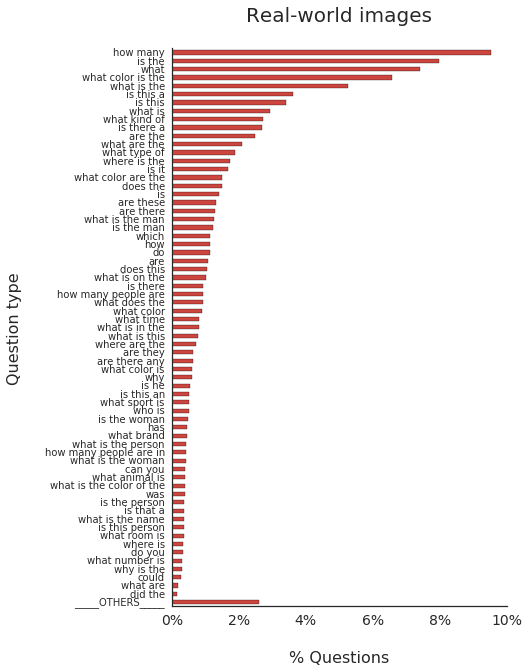

In [14]:
sns.set_palette(sns.color_palette("Reds_d", n_colors=1, desat=0.75))
g = firsts[::-1].set_index('_q_type').percen.plot(kind='barh') #, stacked=True
sns.despine()

g.set_xticklabels(["{}%".format(i) for i in g.get_xticks().astype(int)], fontsize=14)
g.set_title('{}\n'.format(title), fontsize=20)
g.set_xlabel("\n% Questions", fontsize=16)
g.set_ylabel("Question type\n", fontsize=16)

new_firsts = get_differents(firsts, p=1.25, min_count=2, sort=False)
new_firsts = new_firsts.sort_values(by='_count', ascending=False)

('MAX S', 41)


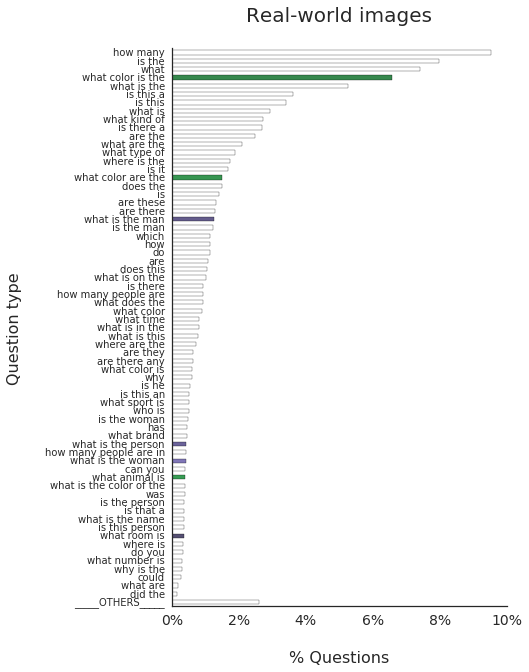

In [15]:
firsts = firsts[::-1]
sats = (firsts._diff.abs().values*1000).astype(int)
print('MAX S', max(sats))
max_stats=75
m_d_colores = {'bottom_up': sns.color_palette("Greens_d", n_colors=max_stats+1),
                'top_down': sns.color_palette("Purples_d", n_colors=max_stats+1) # sns.cubehelix_palette(max_stats+1) #
                }
colors = []
for i, winner in enumerate(firsts.winner):
    if firsts._q_type.values[i] in new_firsts._q_type.values:
        colors.append(m_d_colores[winner][sats[i]])
    else:
        colors.append('white')
g = firsts.set_index('_q_type').percen.plot(kind='barh', color=colors)
g.set_xticklabels(["{}%".format(i) for i in g.get_xticks().astype(int)], fontsize=14)
g.set_title('{}\n'.format(title), fontsize=20)
g.set_xlabel("\n% Questions", fontsize=16)
g.set_ylabel("Question type\n", fontsize=16)
sns.despine()

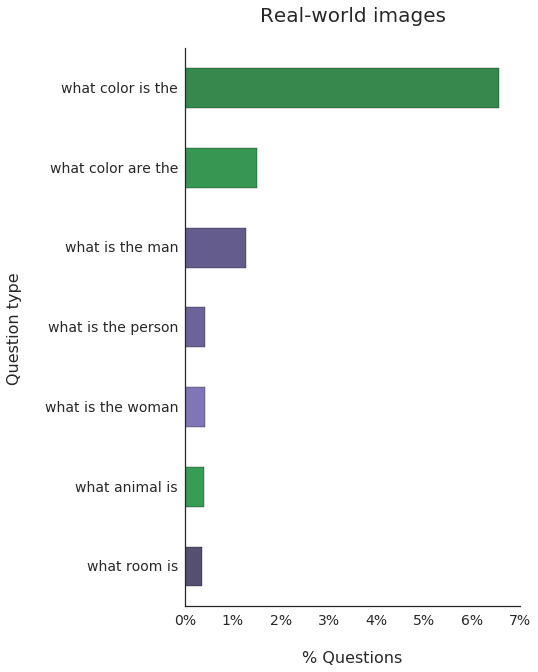

In [16]:
new_firsts = new_firsts[::-1]
sats = (new_firsts._diff.abs().values*1000).astype(int)
colors = []

for i, winner in enumerate(new_firsts.winner):
        colors.append(m_d_colores[winner][sats[i]])
g = new_firsts.set_index('_q_type').percen.plot(kind='barh', color=colors) #, stacked=True

g.set_xticklabels(["{}%".format(i) for i in g.get_xticks().astype(int)], fontsize=14)
g.set_yticklabels(g.get_yticklabels(), fontsize=14)
g.set_title('{}\n'.format(title), fontsize=20)
g.set_xlabel("\n% Questions", fontsize=16)
g.set_ylabel("Question type\n", fontsize=16)
sns.despine()

# Real

In [130]:
scenario = 'real'
summary = get_summary(scenario, _set='val', v='_b')
del summary['o_top_down']
del summary['o_bottom_up']
print('\n')
different = get_differents(summary, p=.65, min_count=2)
different

('scores', array([ 0.63612855,  0.63371339]), True)
('score_sum', array([ 136356.7,  135839. ]), True)
214354


((776, 1), 'shape')
(3.9950000000000001, '% query_types')
(4.1740000000000004, '% queries')
(array([ 6003.2,  5946.3]), True, 'sum_scores')
(56, 'abs diff')
(31, 'len')


,_q_type,sum_bottom_up,count_bottom_up,_count,winner,my_score,base_score,above_median,_diff,diff_score,percen
1137,what color are the,0.517079,0.5,3219,bottom_up,2425.4,2417.4,True,-0.034158,8.0,1.502
118,based on,0.518626,0.5,34,bottom_up,21.3,18.4,True,-0.037252,2.9,0.016
1132,what animal is,0.518064,0.5,833,bottom_up,619.9,618.0,True,-0.036128,1.9,0.389
1237,who are,0.521010,0.5,63,bottom_up,22.2,20.6,True,-0.042019,1.6,0.029
646,on the,0.520975,0.5,3,bottom_up,1.3,0.0,True,-0.041950,1.3,0.001
1340,who rides,0.524430,0.5,7,bottom_up,5.0,4.0,True,-0.048860,1.0,0.003
337,during which,0.522948,0.5,4,bottom_up,3.0,2.0,True,-0.045895,1.0,0.002
1192,where do,0.522466,0.5,48,bottom_up,20.4,19.9,True,-0.044932,0.5,0.022
377,from the,0.519549,0.5,4,bottom_up,1.0,0.6,True,-0.039097,0.4,0.002
99,aside from,0.526140,0.5,3,bottom_up,1.6,1.3,True,-0.052279,0.3,0.001


In [131]:
for d in different[different.winner=='bottom_up'].values:
    print("{}\t{}".format('-'.join(d[0].split()), different.diff_score.mean()+d[-2]))

what-color-are-the	9.83548387097
based-on	4.73548387097
what-animal-is	3.73548387097
who-are	3.43548387097
on-the	3.13548387097
who-rides	2.83548387097
during-which	2.83548387097
where-do	2.33548387097
from-the	2.23548387097
aside-from	2.13548387097
roughly-what	2.13548387097
where-could	2.13548387097
on-what	2.03548387097
whose-shadow	1.93548387097
where-might	1.93548387097


In [132]:
for d in different[different.winner=='top_down'].values:
    print("{}\t{}".format('-'.join(d[0].split()), different.diff_score.mean()+d[-2]))

what-is-the-woman	17.635483871
what-is-the-person	9.73548387097
what-is-the-man	4.53548387097
there-is	4.23548387097
where-these	3.43548387097
who-owns	3.23548387097
who-left	2.83548387097
where-did	2.73548387097
who-wears	2.53548387097
whose-room	2.43548387097
where-has	2.43548387097
who-cleaned	2.23548387097
who-manufactures	2.13548387097
who-had	2.13548387097
whose-home	2.13548387097
who-prepared	1.93548387097


In [133]:
#for d in summary[summary.winner=='bottom_up'].sort_values(by='diff_score', ascending=False)[:20].values:
#    print("{}\t{}".format(d[0], d[3]))

In [134]:
#for d in summary[summary.winner=='top_down'].sort_values(by='diff_score', ascending=False)[:20].values:
#    print("{}\t{}".format(d[0], d[3]))

# Abstract

In [135]:
scenario = 'abstract'
summary = get_summary(scenario, _set='val', v='_b')
del summary['o_top_down']
del summary['o_bottom_up']
print('\n')
different = get_differents(summary, p=.65, min_count=2)
different

('scores', array([ 0.71153   ,  0.71069333]), True)
('score_sum', array([ 21345.9,  21320.8]), True)
30000


((265, 1), 'shape')
(3.3959999999999999, '% query_types')
(14.887, '% queries')
(array([ 2700.8,  2594.8]), True, 'sum_scores')
(106, 'abs diff')
(9, 'len')


,_q_type,sum_bottom_up,count_bottom_up,_count,winner,my_score,base_score,above_median,_diff,diff_score,percen
22,are there any,0.521550,0.5,195,bottom_up,173.2,171.0,True,-0.043101,2.200000e+00,0.650
115,has this,0.504273,0.5,5,bottom_up,3.9,3.3,True,-0.008545,6.000000e-01,0.017
127,how many,0.470949,0.5,2932,top_down,1711.0,1644.5,True,0.058101,6.650000e+01,9.773
128,how many animals are,0.466542,0.5,97,top_down,47.5,34.5,True,0.066916,1.300000e+01,0.323
129,how many birds are,0.468151,0.5,89,top_down,45.1,34.7,True,0.063698,1.040000e+01,0.297
130,how many bushes,0.462404,0.5,88,top_down,47.7,40.2,True,0.075192,7.500000e+00,0.293
322,what is in the,0.470121,0.5,355,top_down,232.8,229.3,True,0.059759,3.500000e+00,1.183
323,what is on the,0.462054,0.5,584,top_down,348.4,346.1,True,0.075892,2.300000e+00,1.947
134,how many pillows,0.465845,0.5,121,top_down,91.2,91.2,True,0.068310,1.421085e-14,0.403


In [136]:
different._count.value_counts()

355     1
584     1
89      1
88      1
5       1
2932    1
195     1
97      1
121     1
Name: _count, dtype: int64

In [137]:
for d in different[different.winner=='bottom_up'].values:
    print("{}\t{}".format('-'.join(d[0].split()), different.diff_score.mean()+d[-2]))

are-there-any	13.9777777778
has-this	12.3777777778


In [138]:
for d in different[different.winner=='top_down'].values:
    print("{}\t{}".format('-'.join(d[0].split()), different.diff_score.mean()+d[-2]))

how-many	78.2777777778
how-many-animals-are	24.7777777778
how-many-birds-are	22.1777777778
how-many-bushes	19.2777777778
what-is-in-the	15.2777777778
what-is-on-the	14.0777777778
how-many-pillows	11.7777777778


In [30]:
#for d in summary[summary.winner=='bottom_up'].sort_values(by='diff_score', ascending=False)[:20].values:
#    print("{}\t{}".format(d[0], d[3]))

In [31]:
#for d in summary[summary.winner=='top_down'].sort_values(by='diff_score', ascending=False)[:20].values:
#    print("{}\t{}".format(d[0], d[3]))